# Estimacion de produccion de Aceite

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,12)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }
# plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import sys
sys.path.append('serch_tools/')
import serch_tools as st

from pdpbox import pdp, info_plots
from sklearn.cluster import KMeans
import plotly
import cufflinks

In [2]:
# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

In [3]:
aforos = pd.read_csv("datos/aforos.csv")
analisis_fluidos = pd.read_csv("datos/Analisis_fluidos.csv")
columna_geologica = pd.read_csv('datos/columna_geologica.csv')
eval_petrofisica = pd.read_csv('datos/eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('datos/IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('datos/parametros_petrofisicos.csv')

In [4]:
datos_generales_pozos = pd.read_csv('datos/datos_generales_de_pozos.csv')
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[:6] + datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[8:]
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos['CLASIFICACION_LAHEE'].str.replace("/","-")

In [5]:
prod_mens = pd.read_csv('datos/produccion_mensual.csv')
prod_mens.head()

,index,NOMBRE_DEL_POZO,CIMA_INTERVALO_(md),BASE_INTERVALO_(md),CONDICION_DE_FLUJO_(Fluyente/SAP),FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa),RELACION_GAS_LIQUIDO_(m3/m3),RELACION_GAS_ACEITE_(m3/m3),CORTE_DE_AGUA_(bl/bl),SALINIDAD_(PPM),...,RELACION_CONDENSADO_GAS_(m3/m3),RELACION_AGUA_GAS_(m3/m3),RELACION_AGUA_CONDENSADO_(m3/m3),FRACCION_DEL_SEDIMENTO,DIAMETRO_DEL_ESTRANGULADOR _(in),VOLUMEN_DE_ACEITE_(m3),VOLUMEN_DE_GAS_(m3),VOLUMEN_DE_CONDENSADO_(m3),DIAS_DE_PRODUCCION,DESCRIPCION_DE_LA_PRODUCCION
0,0,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/10/2013,101.175571,203.152074,50.205197,SIN INFORMACION,...,NO APLICA,0.004962,NO APLICA,NO APLICA,NO APLICA,31.803914,6462.078342,NO APLICA,31,SIN INFORMACION
1,1,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/11/2013,100.298703,203.279313,50.667656,SIN INFORMACION,...,NO APLICA,0.005052,NO APLICA,NO APLICA,NO APLICA,29.536942,6005.222347,NO APLICA,30,SIN INFORMACION
2,2,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/12/2013,101.159166,203.859067,50.385933,SIN INFORMACION,...,NO APLICA,0.004981,NO APLICA,NO APLICA,NO APLICA,30.852725,6290.627114,NO APLICA,31,SIN INFORMACION
3,3,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/01/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,31.774044,6464.681785,NO APLICA,31,SIN INFORMACION
4,4,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/02/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,28.699137,5839.067419,NO APLICA,28,SIN INFORMACION


In [6]:
prod_mens.columns

Index(['index', 'NOMBRE_DEL_POZO', 'CIMA_INTERVALO_(md)',
       'BASE_INTERVALO_(md)', 'CONDICION_DE_FLUJO_(Fluyente/SAP)',
       'FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)', 'RELACION_GAS_LIQUIDO_(m3/m3)',
       'RELACION_GAS_ACEITE_(m3/m3)', 'CORTE_DE_AGUA_(bl/bl)',
       'SALINIDAD_(PPM)', 'RELACION_AGUA_ACEITE_(m3/m3)',
       'RELACION_CONDENSADO_GAS_(m3/m3)', 'RELACION_AGUA_GAS_(m3/m3)',
       'RELACION_AGUA_CONDENSADO_(m3/m3)', 'FRACCION_DEL_SEDIMENTO',
       'DIAMETRO_DEL_ESTRANGULADOR _(in)', 'VOLUMEN_DE_ACEITE_(m3)',
       'VOLUMEN_DE_GAS_(m3)', 'VOLUMEN_DE_CONDENSADO_(m3)',
       'DIAS_DE_PRODUCCION ', 'DESCRIPCION_DE_LA_PRODUCCION '],
      dtype='object')

In [7]:
prod_mens.groupby(['NOMBRE_DEL_POZO'])['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'].count().median()

121.0

In [8]:
prod_mens['fecha_produccion'] = pd.to_datetime(prod_mens['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'], 
                                               format="%d/%m/%Y")

In [9]:
prod_mens['fecha_produccion'].describe()

count                   20821
unique                    187
top       1999-01-01 00:00:00
freq                      156
first     1999-01-01 00:00:00
last      2014-07-01 00:00:00
Name: fecha_produccion, dtype: object

En algunos posos tenemos un historico de 1999 hasta 2014

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [10]:
db_prod_mol = pd.read_csv('datos/DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [11]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [12]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [13]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 6 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_1 P(t-2)+ \beta_1 P(t-3)+ \beta_1 P(t-4)+ \beta_1 P(t-5)+ \beta_1 P(t-6) + \epsilon$

In [14]:
# tabla (t - 12)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t - 11)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

# tabla (t -10)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-2)

# tabla (t - 9)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-3)

# tabla (t - 8)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-4)

# tabla (t -7)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-5)

# tabla (t - 6)
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-6)

#tabla (t - 5)
t_7 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-7)

#tabla (t - 4) 
t_8 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-8)

#tabla (t - 3) 
t_9 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-9)

#tabla (t - 2) 
t_10 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-10)

#tabla (t - 1) 
t_11 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-11)

#tabla (t)  variable a estimar
t_12 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-12)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [15]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12],1).dropna()
df.columns = ['Produccion_barriles_t_12','Produccion_barriles_t_11','Produccion_barriles_t_10',
              'Produccion_barriles_t_9','Produccion_barriles_t_8','Produccion_barriles_t_7',
              'Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t']

In [16]:
# df = pd.concat([df,t_7],1)
# df.columns = ['Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
#               'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
#               'Produccion_barriles_t','Produccion_barriles_t_mas_1']

In [17]:
df.shape # numero de registros

(20874, 13)

In [18]:
df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1

df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1

df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']

In [19]:
df.columns

Index(['Produccion_barriles_t_12', 'Produccion_barriles_t_11',
       'Produccion_barriles_t_10', 'Produccion_barriles_t_9',
       'Produccion_barriles_t_8', 'Produccion_barriles_t_7',
       'Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1',
       'Produccion_barriles_t', 'diff_t_6_t_5', 'diff_t_5_t_4', 'diff_t_4_t_3',
       'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1', 'diff_t_5_t_1',
       'diff_t_4_t_1', 'diff_t_3_t_1', 'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1'],
      dtype='object')

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [20]:
# desviacion estandar
df['std_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
# mediana
df['median_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
# minimo
df['min_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
#quantiles
df['q75_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
df['q25_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
df['q90_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
df['q10_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
#maximo
df['max_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

#rango
df['rango_t6_t1'] = df['max_t_6_t_1'] - df['min_t_6_t_1']

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor
+  rango Acota la produccion esperada para no sobreestimar
+ quantiles en 6 meses

In [21]:
# medias moviles
df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

Se crean variables de medias moviles

In [22]:
[['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1','std_t_6_t_1']]

[['Produccion_barriles_t_1',
  'Produccion_barriles_t',
  'Produccion_barriles_t_mas_1',
  'std_t_6_t_1']]

In [23]:
df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 5*df.std_t_6_t_1 > df.Produccion_barriles_t,1,0)

In [25]:
df[df.dummi_pico_bajo==1].shape

(856, 39)

In [26]:
df = df[df.dummi_pico_bajo!=1]

In [27]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

dummie de mes

In [28]:
# tabla dummies_month
dummi_month = pd.get_dummies(db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6).dt.month.dropna().astype(int).dropna(),prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2002-06-01              1        0        0        0        0   
              2002-07-01              0        1        0        0        0   
              2002-08-01              0        0        1        0        0   
              2002-09-01              0        0        0        1        0   
              2002-10-01              0        0        0        0        1   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2002-06-01              0        0        0        0         0   
              2002-07-01              0        0        0        0         0   
              2002-08-01              0        0        0        0         0   
              2002-09-01              0        0        0        0         0   
              2002-10-01              0        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2002-06-01               0         0  
              2002-07-01               0         0  
              2002-08-01               0         0  
              2002-09-01               0         0  
              2002-10-01               0         0

In [29]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

## Si estuvo detenido

In [30]:
# detenido_mes_anterior = pd.DataFrame(np.where(((db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-6) - db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-5))/np.timedelta64(1,"D")) < 31, 1, 0), index=db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().index, columns=['detenido_mes_antes'])
# detenido_mes_anterior.head()

In [31]:
# df = pd.merge(df, detenido_mes_anterior, right_index=True, left_index=True)

# Latitud y longitud

In [32]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [33]:
df_train = df.reset_index().merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [34]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud
214,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,186.59,...,0,0,1,0,0,0,0,0,17.985929,-94.370707
215,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,197.52,...,0,0,0,1,0,0,0,0,17.985929,-94.370707
216,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,215.72,...,0,0,0,0,1,0,0,0,17.985929,-94.370707
217,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,185.47,...,0,0,0,0,0,1,0,0,17.985929,-94.370707
218,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,137.72,...,0,0,0,0,0,0,1,0,17.985929,-94.370707


In [35]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2

# Variable de tecnologia
Se le pega el nombre del equipo de perforacion para saber si es mejor o peor para la produccion

In [36]:
# pegar a pozo nombre_equipo_perfo
nombre_equi_perfo = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['NOMBRE_EQUIPO_DE_PERFORACION'].first())
nombre_equi_perfo.reset_index(inplace=True)
nombre_equi_perfo.columns = ['Pozo','equipo_perforacion']
# se encontraron inconsistencias en la info
nombre_equi_perfo["equipo_perforacion"] = nombre_equi_perfo.equipo_perforacion.str.replace(
    "PM5597-","PM-5597").str.replace(
    "PM.-5597","PM-5597").str.replace(
    "PM.5599","PM-5599")
nombre_equi_perfo.head()

,Pozo,equipo_perforacion
0,MOLOACAN-1,SIN INFORMACION
1,MOLOACAN-101,SIN INFORMACION
2,MOLOACAN-102,SIN INFORMACION
3,MOLOACAN-102A,PM-5597
4,MOLOACAN-11,PM-111


In [37]:
df_train = df_train.merge(nombre_equi_perfo, how='left',on='Pozo').dropna()

In [38]:
df_train = pd.get_dummies(df_train, columns=['equipo_perforacion'])

In [39]:
df_train.shape

(19624, 69)

# variable clasificaccion LAHEE
La Clasificación Lahee, los pozos pueden ser identificados como:
+ Pozo Exploratorio
+ Pozos Productores
+ Pozos no Productores (Secos)
+ Pozos de Desarrollo
+ Pozo de Avanzada

Codigos

    07-07-01 - Pozo de desarrollo, productor aceite
    07-07-06 - Pozo de desarrollo, improductivo, invadido de agua salada
    07-07-13 - 07 Pozo de desarrollo
    07-07-04 - Pozo de desarrollo, productor incosteable
    07-07-07 - Pozo de desarrollo, improductivo seco
    04-04-01 - Pozo en busca de nueva acumulacion en campo ya productor, productor de aceite
    07-01-00 - 07 Pozo de desarrollo
    04-04-06 - Pozo en busca de nueva acumulacion en campo ya productor, improductivo, invadido de agua salada
    01-01-06 - Pozo en busca de nueva acumulacion, improductivo, invadido de agua salada
    SIN INFORMACION

Referencia de codigos https://bndh.gob.do/wp-content/uploads/2016/04/4.3-MEM-BNDH-RD-Tercer-Informe-de-Avances_v2-1.pdf

In [40]:
clasifi_lahee = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['CLASIFICACION_LAHEE'].first())
clasifi_lahee.reset_index(inplace=True)
clasifi_lahee.columns = ['Pozo','clasificacion_lahee']
clasifi_lahee.head()

,Pozo,clasificacion_lahee
0,MOLOACAN-1,07-07-01
1,MOLOACAN-101,07-07-07
2,MOLOACAN-102,07-07-06
3,MOLOACAN-102A,07-07-01
4,MOLOACAN-11,07-07-01


In [41]:
df_train = df_train.merge(clasifi_lahee, how='left',on='Pozo').dropna()

In [42]:
df_train = pd.get_dummies(df_train, columns=['clasificacion_lahee'])

In [43]:
df_train.shape

(19624, 71)

In [44]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,equipo_perforacion_PM-5599,equipo_perforacion_PM-5620,equipo_perforacion_PM-5626,equipo_perforacion_PM-5627,equipo_perforacion_PM-73,equipo_perforacion_PM-78,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION
0,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,186.59,...,0,0,0,0,0,0,0,1,1,0
1,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,197.52,...,0,0,0,0,0,0,0,1,1,0
2,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,215.72,...,0,0,0,0,0,0,0,1,1,0
3,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,185.47,...,0,0,0,0,0,0,0,1,1,0
4,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,137.72,...,0,0,0,0,0,0,0,1,1,0


# pendiente pico historico

In [45]:
# df_d_prod = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-6).reset_index()
# db_prod_mol['fecha_y'] = df_d_prod.f_prod

In [46]:
# for i in db_prod_mol.groupby('Pozo')[['Qo_mes_b','fecha_produccion','fecha_y']]:
#     print(i[0])
#     print(i[1][i[1].fecha_produccion >= i[1].fecha_y])

In [47]:
# y_temp = []
# for i in sample_prod_data.groupby('API')['Liquid']:
# #     print(i[0])
# #     print(i[1][i[1].index >= idx_prod_max_api[i[0]]].sum())
#     y_temp.append([i[0], i[1][i[1].index >= idx_prod_max_api[i[0]]].sum()])

In [48]:
# idx_prod_max_api = prod_data_train.groupby('API').Liquid.idxmax()

In [49]:
# # AQUI SE CREA LA Y (se puede hacer lista de comprension)
# pico_temp = []
# for i in db_prod_mol.groupby('Pozo')['Qo_mes_b']:
#     pico_temp.append([i[0], i[1][i[1].fecha_produccion >= idx_prod_max_api[i[0]]].sum()])

In [50]:
# db_prod_mol.columns

In [51]:
# db_prod_mol.groupby('Pozo')[['fecha_produccion','f_prod']].last()

In [52]:
# db_prod_mol.groupby(
#     ['Pozo','fecha_produccion'])

In [53]:
df_train.shape

(19624, 71)

## Quitamos Outliers

In [54]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2

In [55]:
df_train = df_train[df_train.Produccion_barriles_t > df_train.Produccion_barriles_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_barriles_t_1 > df_train.Produccion_barriles_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_2 > df_train.Produccion_barriles_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_3 > df_train.Produccion_barriles_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_4 > df_train.Produccion_barriles_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_5 > df_train.Produccion_barriles_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_6 > df_train.Produccion_barriles_t_6.quantile(0.001)]

In [56]:
df_train = df_train[df_train.Produccion_barriles_t < df_train.Produccion_barriles_t.quantile(0.99)]

In [57]:
df_train = df_train[df_train.Produccion_barriles_t_1 < df_train.Produccion_barriles_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_2 < df_train.Produccion_barriles_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_3 < df_train.Produccion_barriles_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_4 < df_train.Produccion_barriles_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_5 < df_train.Produccion_barriles_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_6 < df_train.Produccion_barriles_t_6.quantile(0.99)]

In [58]:
df_train.reset_index(inplace=True, drop=True)

In [59]:
df_train.shape

(18040, 71)

# Clustering Vemos que hay tipos de pozos con produccion similar

In [60]:
from sklearn.cluster import KMeans

In [61]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2

In [62]:
num_cols = ['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1',
        
        'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
            
       'aceleracion_de_produccion _t3t2_t2t1', 
            'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 
            'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1',
         'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 
            #'detenido_mes_antes',
       'latitud', 'longitud', 
            'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION', 
            'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION']

In [63]:
df_std = (df_train[num_cols] - df_train[num_cols].mean()) / df_train[num_cols].std()

In [64]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_std)
    Sum_of_squared_distances.append(km.inertia_)

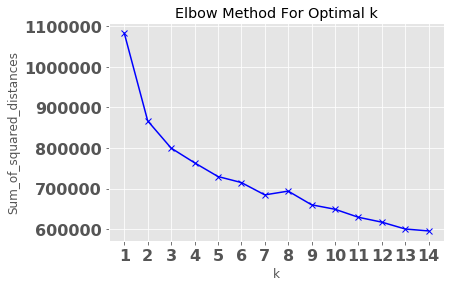

In [65]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(1,15));

In [66]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [67]:
df_train = pd.concat([df_train,pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [68]:
df_train["cluster"] = kmeans.predict(df_std)

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [69]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2

# AED

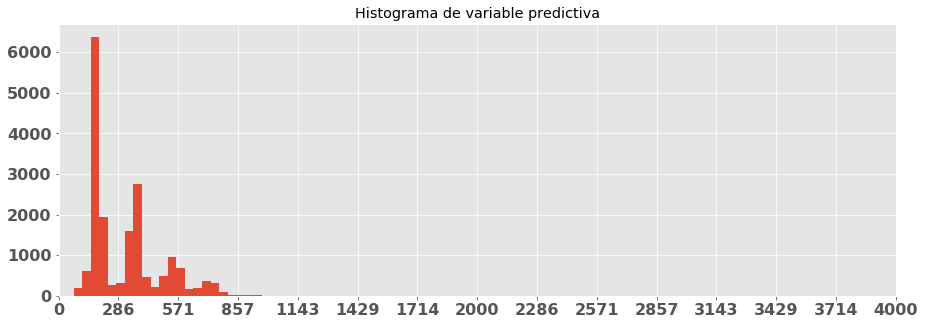

In [70]:
df_train.Produccion_barriles_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
plt.xticks(np.linspace(0,4000,15));

# Dispersiones

In [71]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2

In [72]:
num_cols = ['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 
            'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 
            'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 
            #'detenido_mes_antes',
       'latitud', 'longitud',
            'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION', 'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION', 
            'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster']

En algun momento dibujaras un mapa aqui

In [73]:
lat = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
lon = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
idx = df_train.groupby('Pozo')[['latitud','longitud']].first().index.values

In [74]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2

Text(0.5, 1.0, 'Observamos que hay pozos estables en cantidad de produccion y\n            otros que ascienden o descienden en produccion')

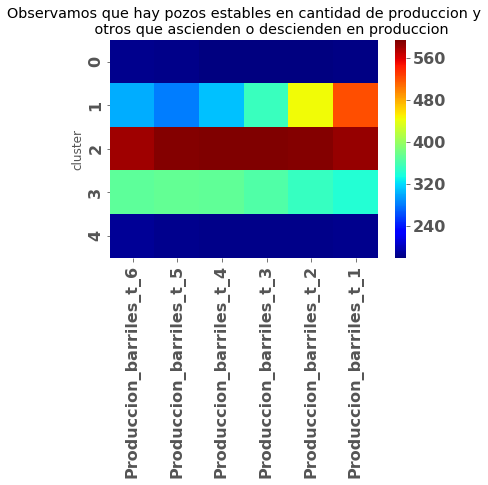

In [75]:
sns.heatmap(df_train.groupby('cluster')[[ 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1']].mean(),cmap='jet')
plt.title('''Observamos que hay pozos estables en cantidad de produccion y
            otros que ascienden o descienden en produccion''')

# Entrenamiento

Analisis con h2o no obtuvo mejores resultados, se carga el modelo light_gbm_31-07-2019.pkl

In [76]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_12',
       'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
       'Produccion_barriles_t_9', 'Produccion_barriles_t_8',
       'Produccion_barriles_t_7', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2

In [78]:
num_cols =['Produccion_barriles_t_12', 'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
           'Produccion_barriles_t_9', 'Produccion_barriles_t_8', 'Produccion_barriles_t_7', 
           'Produccion_barriles_t_6', 'Produccion_barriles_t_5', 'Produccion_barriles_t_4', 
           'Produccion_barriles_t_3', 'Produccion_barriles_t_2', 'Produccion_barriles_t_1']

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
def train_test_valid_split(df, x_cols, y_col):
    
    x_train_test, x_valid, y_train_test, y_valid = train_test_split(
    df[x_cols],
    df[y_col],
    test_size=0.1,
    random_state=8)

    x_train, x_test, y_train, y_test = train_test_split(x_train_test, 
                                                    y_train_test,
                                                    test_size = 0.2,
                                                    random_state=10)
    
    return x_train, x_test, x_valid, y_train, y_test, y_valid

In [81]:
x_train, x_test, x_valid, y_train, y_test, y_valid = train_test_valid_split(df_train, 
                                                                               num_cols, 'Produccion_barriles_t')

In [82]:
x_train.shape

(12988, 12)

In [83]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 50
params['min_data'] = 1
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 1000, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1764]	valid_0's l1: 24.0318


In [84]:
clf.num_trees()

1764

# Evaluacion

In [85]:
y_pred = clf.predict(x_valid)

In [86]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("R^2: %1.4f" % R2)
    
    print("R^2 ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))

In [87]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

R^2: 0.8833
R^2 ajustada$: 0.8826
MEA: 25.3237
MSE 3244.1810
RMSE 56.9577


In [88]:
def yy_plot(y_real, y_pred):
    plt.scatter(y_real, y_pred, alpha=0.5)
    mi2,ma2 = y_real.min(), y_real.max()
    mi1,ma1 = y_pred.min(), y_pred.max()
    plt.plot([mi2,ma2],[mi1,ma1], linestyle='--', color='navy')
    plt.xlabel('Y_real')
    plt.ylabel('Y_estimada')

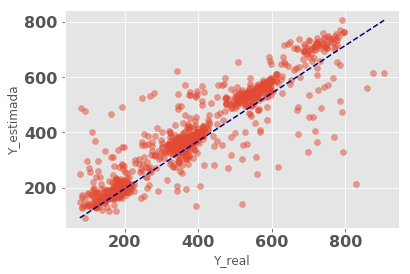

In [89]:
yy_plot(y_valid, y_pred)

## Residuos

In [90]:
res = (y_valid - y_pred) / y_valid

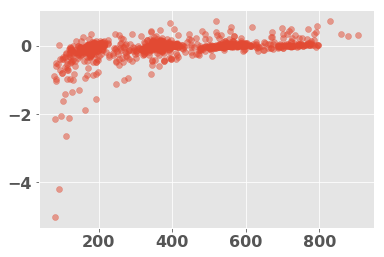

In [91]:
plt.scatter(y_valid, res, alpha=0.5)

In [92]:
pd.DataFrame(res).median() * 100

Produccion_barriles_t   -0.012931
dtype: float64

In [93]:
res.mean() * 100

-3.5328222025471825

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

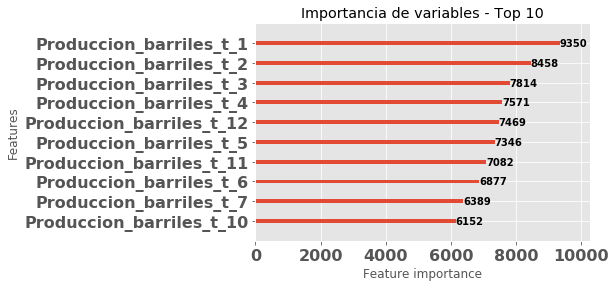

In [94]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [95]:
explainer, shap_values = st.shap_shap(clf, x_valid)

AttributeError: module 'serch_tools' has no attribute 'shap_shap'

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [ ]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

In [ ]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Check de pozos aleatorios

In [ ]:
idx = df_train.Pozo.sample(10)

In [ ]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().index

In [ ]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().unstack(0)

In [ ]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [ ]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

In [ ]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [ ]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [ ]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_barriles_t

In [ ]:
df_train['prediction'] = preds

In [ ]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [ ]:
df_train.groupby('Pozo').fecha_produccion.count().median()

In [ ]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [ ]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [ ]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [ ]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10)

In [ ]:
# df_vivos2.columns = ['Produccion_promedio', 'prediction', 'prediccion_q90', 'prediccion_q10']

In [ ]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

# Carga de modelo

In [96]:
#from sklearn.externals import joblib

In [97]:
# carga de modelo
#gbm_pickle = joblib.load('modelos/light_gbm_31-07-2019.pkl')

# Generador de serie de tiempo

In [234]:
df_simul = df_train[df_train.Pozo == 'MOLOACAN-836'].reset_index(drop=True)
#df_simul.drop(['Qomes_b_t_log','cluster'], 1, inplace=True)
#df_simul.drop(['cluster'], 1, inplace=True)
df_simul['y_real'] = df_simul.Produccion_barriles_t

In [235]:
df_simul.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

In [98]:
# variables a utilizar
num_cols =['Produccion_barriles_t_12', 'Produccion_barriles_t_11', 'Produccion_barriles_t_10',
           'Produccion_barriles_t_9', 'Produccion_barriles_t_8', 'Produccion_barriles_t_7', 
           'Produccion_barriles_t_6', 'Produccion_barriles_t_5', 'Produccion_barriles_t_4', 
           'Produccion_barriles_t_3', 'Produccion_barriles_t_2', 'Produccion_barriles_t_1']

In [237]:
def gen_cols(df):
    
    df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
    df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
    df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
    df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2
    df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1

    df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
    df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
    df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
    df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1

    df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
    df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']
    
    # desviacion estandar
    df['std_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
    # mediana
    df['median_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
    # minimo
    df['min_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
    #quantiles
    df['q75_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
    df['q25_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
    df['q90_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
    df['q10_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
    #maximo
    df['max_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

    #rango
    df['rango_t6_t1'] = df['max_t_6_t_1'] - df['min_t_6_t_1']
    
    # medias moviles
    df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                    'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                                   'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

    df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                                   'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    
    #dummi pico abajo
    #df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 5*df.std_t_6_t_1 > df.Produccion_barriles_t,1,0)
    
    # dummies_month
    #pd.get_dummies(df.reset_index().fecha_produccion.dt.month,prefix='month')
    
    #y_real
    df['y_real'] = df_simul.Produccion_barriles_t

    return df

In [99]:
def forecast(df,n_pred,lag,columna_inicial,num_cols):
    pred=[]
    for i in range(n_pred):
        # prediccion de la ultima fila
        valor=gbm_pickle.predict(df[num_cols][-1:])
        # genera una nueva fila
        df=pd.concat([df,df.iloc[-1:]],ignore_index=True)
        for j in range(lag-1):
            # recorrer valores
            df.iloc[-1,j+columna_inicial] = df.iloc[-1,j+1+columna_inicial]
        
        
        df.iloc[-1,columna_inicial+lag-1]=valor
        #gen_cols(df)
        # colocar el valor de la predicción
        #valor=gbm_pickle.predict(df[num_cols][-1:])
        pred.append(valor)
        #df.iloc[-1,columna_inicial+lag-1]=valor
        # calcular las variables que dependen en el tiempo
        #gen_cols(df)
        # calcular la y_real
        df.iloc[-1,-1]=valor
    return df,pred

In [110]:
n_pred=3
lag=7
columna_inicial=2

In [111]:
df_prueba.tail()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,y_real
32,MOLOACAN-836,2005-04-01,191.55,137.41,263.06,300.87,329.710000,325.870000,349.330000,502.73,...,0,0,1,0,1,0,0,0,0,349.330000
33,MOLOACAN-836,2005-05-01,137.41,263.06,300.87,329.71,325.870000,349.330000,502.730000,563.98,...,0,0,1,0,0,1,0,0,0,502.730000
34,MOLOACAN-836,2005-05-01,263.06,300.87,329.71,325.87,349.330000,502.730000,620.367143,563.98,...,0,0,1,0,0,1,0,0,0,NaN
35,MOLOACAN-836,2005-05-01,300.87,329.71,325.87,349.33,502.730000,620.367143,643.832197,563.98,...,0,0,1,0,0,1,0,0,0,NaN
36,MOLOACAN-836,2005-05-01,329.71,325.87,349.33,502.73,620.367143,643.832197,655.159091,563.98,...,0,0,1,0,0,1,0,0,0,655.159091


In [112]:
pred

[620.3671433166517, 643.8321970082912, 655.1590910845613]

In [386]:
df_prueba.index

RangeIndex(start=0, stop=154, step=1)

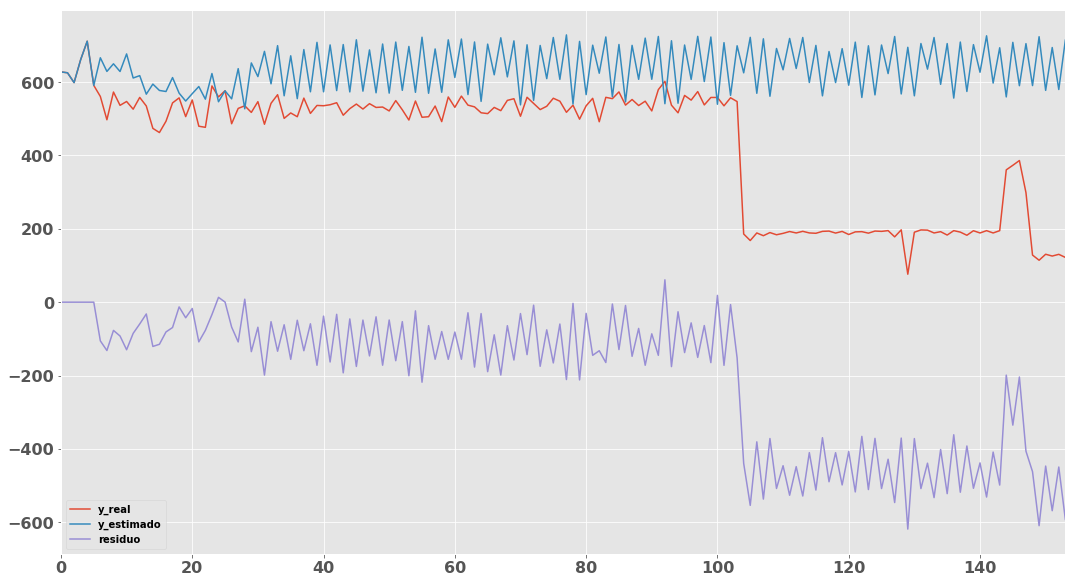

In [387]:
algo = pd.concat([df_prueba[["Produccion_barriles_t"]],df_simul[["Produccion_barriles_t"]]], 1)

algo.columns = ["y_real","y_estimado"]
algo["residuo"] = algo.y_real - algo.y_estimado

algo.plot(figsize=(18,10))

In [217]:
algo.iplot()

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

# Forecasting

Forecasting para todos los pozos activos

In [164]:
# pozos vivos
df_train.groupby('Pozo').fecha_produccion.count().median()
# aproximandamente 10 mediciones por pozo
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[df_train.groupby('Pozo').fecha_produccion.count() > 110].index
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [185]:
df_vivos.Pozo.unique()

array(['MOLOACAN-111', 'MOLOACAN-112', 'MOLOACAN-132', 'MOLOACAN-186',
       'MOLOACAN-313', 'MOLOACAN-319', 'MOLOACAN-320', 'MOLOACAN-324',
       'MOLOACAN-325', 'MOLOACAN-327', 'MOLOACAN-329', 'MOLOACAN-330',
       'MOLOACAN-337', 'MOLOACAN-339', 'MOLOACAN-340', 'MOLOACAN-343',
       'MOLOACAN-344', 'MOLOACAN-350', 'MOLOACAN-351', 'MOLOACAN-355',
       'MOLOACAN-357', 'MOLOACAN-367', 'MOLOACAN-375', 'MOLOACAN-376',
       'MOLOACAN-387', 'MOLOACAN-388', 'MOLOACAN-395', 'MOLOACAN-396',
       'MOLOACAN-4', 'MOLOACAN-406', 'MOLOACAN-408', 'MOLOACAN-409',
       'MOLOACAN-414', 'MOLOACAN-416', 'MOLOACAN-421', 'MOLOACAN-422',
       'MOLOACAN-431', 'MOLOACAN-432', 'MOLOACAN-440', 'MOLOACAN-454',
       'MOLOACAN-459', 'MOLOACAN-461', 'MOLOACAN-462', 'MOLOACAN-468',
       'MOLOACAN-470', 'MOLOACAN-475', 'MOLOACAN-483', 'MOLOACAN-485',
       'MOLOACAN-503', 'MOLOACAN-511', 'MOLOACAN-513', 'MOLOACAN-515',
       'MOLOACAN-518', 'MOLOACAN-589', 'MOLOACAN-617', 'MOLOACAN-620',
       '

In [209]:
df_pred=pd.DataFrame()
for i in range(df_vivos.Pozo.unique().shape[0]):
    #selecciona un pozo vivo de la lista de pozos vivos
    df_prueba = df_train[df_train.Pozo == df_vivos.Pozo.unique()[i]].reset_index(drop=True)
    df_prueba['y_real'] = df_prueba.Produccion_barriles_t
    #toma los primeros 6 meses
    df_simul=df_prueba.iloc[0:6]
    #forecast
    n_pred=df_prueba.shape[0]-6
    lag=7
    columna_inicial=2
    df_simul,pred=forecast(df_simul,n_pred,lag,columna_inicial,num_cols)
    #guarda la misma fecha
    df_simul['fecha_produccion']=df_prueba['fecha_produccion']
    #guarda los resultados en un dataframe
    df_pred=pd.concat([df_pred,df_simul],ignore_index=True)

In [210]:
df_pred.shape

(12691, 73)

In [214]:
df_pred.head(10)

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster,y_real
0,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.100000,182.030000,177.280000,191.660000,186.59,...,1,1,0,1,0,0,0,0,0,191.66
1,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.030000,177.280000,191.660000,186.590000,197.52,...,1,1,0,1,0,0,0,0,0,186.59
2,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.280000,191.660000,186.590000,197.520000,215.72,...,1,1,0,1,0,0,0,0,0,197.52
3,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.660000,186.590000,197.520000,215.720000,185.47,...,1,1,0,1,0,0,0,0,0,215.72
4,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.590000,197.520000,215.720000,185.470000,137.72,...,1,1,0,1,0,0,0,0,0,185.47
5,MOLOACAN-111,1999-06-01,177.28,191.66,186.59,197.520000,215.720000,185.470000,137.720000,159.89,...,1,1,0,1,0,0,0,0,0,137.72
6,MOLOACAN-111,1999-07-01,191.66,186.59,197.52,215.720000,185.470000,137.720000,356.652239,159.89,...,1,1,0,1,0,0,0,0,0,NaN
7,MOLOACAN-111,1999-08-01,186.59,197.52,215.72,185.470000,137.720000,356.652239,448.226394,159.89,...,1,1,0,1,0,0,0,0,0,NaN
8,MOLOACAN-111,1999-09-01,197.52,215.72,185.47,137.720000,356.652239,448.226394,650.156254,159.89,...,1,1,0,1,0,0,0,0,0,NaN
9,MOLOACAN-111,1999-10-01,215.72,185.47,137.72,356.652239,448.226394,650.156254,664.431739,159.89,...,1,1,0,1,0,0,0,0,0,NaN


In [215]:
df_pred.tail(10)

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster,y_real
12681,MOLOACAN-893,2011-05-01,555.685760,541.744616,557.613953,568.978971,557.517651,557.791500,562.799032,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12682,MOLOACAN-893,2011-06-01,541.744616,557.613953,568.978971,557.517651,557.791500,562.799032,567.218838,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12683,MOLOACAN-893,2011-07-01,557.613953,568.978971,557.517651,557.791500,562.799032,567.218838,569.075652,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12684,MOLOACAN-893,2011-08-01,568.978971,557.517651,557.791500,562.799032,567.218838,569.075652,568.702008,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12685,MOLOACAN-893,2011-09-01,557.517651,557.791500,562.799032,567.218838,569.075652,568.702008,563.360225,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12686,MOLOACAN-893,2011-10-01,557.791500,562.799032,567.218838,569.075652,568.702008,563.360225,573.161759,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12687,MOLOACAN-893,2011-11-01,562.799032,567.218838,569.075652,568.702008,563.360225,573.161759,569.950022,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12688,MOLOACAN-893,2012-01-01,567.218838,569.075652,568.702008,563.360225,573.161759,569.950022,570.040871,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12689,MOLOACAN-893,2012-02-01,569.075652,568.702008,563.360225,573.161759,569.950022,570.040871,571.477424,158.58,...,0,1,0,1,0,0,0,0,0,NaN
12690,MOLOACAN-893,2012-03-01,568.702008,563.360225,573.161759,569.950022,570.040871,571.477424,568.726501,158.58,...,0,1,0,1,0,0,0,0,0,568.726501


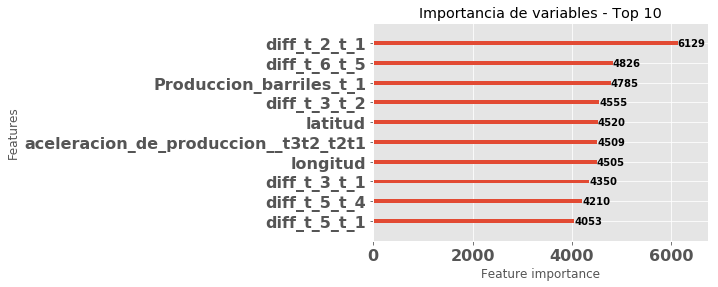

In [218]:
lgb.plot_importance(gbm_pickle,max_num_features=10, title='Importancia de variables - Top 10')

In [220]:
df_vivos.shape

(12691, 72)

In [226]:
df_imp = pd.DataFrame()
df_imp['diff_t_2_t_1_real'] = df_vivos['diff_t_2_t_1']
df_imp['diff_t_2_t_1_estimada'] = df_pred['diff_t_2_t_1']
df_imp[6:].head(10)

,diff_t_2_t_1_real,diff_t_2_t_1_estimada
6,47.75,47.750000
7,-22.17,-218.932239
8,8.29,-91.574155
9,-10.27,-201.929860
10,15.16,-14.275484
11,-5.36,-106.291591
12,-3.03,65.938273
13,-11.46,-36.276956
14,12.63,2.750395
15,19.10,24.650987


In [ ]:
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1

In [227]:
num_cols2=['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1']

In [230]:
df_pred[num_cols2][6:].head(10)

,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,diff_t_6_t_5,diff_t_5_t_4,diff_t_4_t_3,diff_t_3_t_2,diff_t_2_t_1,diff_t_6_t_1,diff_t_5_t_1,diff_t_4_t_1,diff_t_3_t_1,aceleracion_de_produccion _t3t2_t2t1,aceleracion_de_produccion _t4t3_t2t1
6,191.660000,186.590000,197.520000,215.720000,185.470000,137.720000,356.652239,5.070000,-10.930000,-18.200000,30.250000,47.750000,53.940000,48.870000,59.800000,78.000000,-17.500000,-65.950000
7,186.590000,197.520000,215.720000,185.470000,137.720000,356.652239,448.226394,-10.930000,-18.200000,30.250000,47.750000,-218.932239,-170.062239,-159.132239,-140.932239,-171.182239,266.682239,249.182239
8,197.520000,215.720000,185.470000,137.720000,356.652239,448.226394,650.156254,-18.200000,30.250000,47.750000,-218.932239,-91.574155,-250.706394,-232.506394,-262.756394,-310.506394,-127.358084,139.324155
9,215.720000,185.470000,137.720000,356.652239,448.226394,650.156254,664.431739,30.250000,47.750000,-218.932239,-91.574155,-201.929860,-434.436254,-464.686254,-512.436254,-293.504015,110.355705,-17.002379
10,185.470000,137.720000,356.652239,448.226394,650.156254,664.431739,770.723329,47.750000,-218.932239,-91.574155,-201.929860,-14.275484,-478.961739,-526.711739,-307.779499,-216.205344,-187.654375,-77.298671
11,137.720000,356.652239,448.226394,650.156254,664.431739,770.723329,704.785056,-218.932239,-91.574155,-201.929860,-14.275484,-106.291591,-633.003329,-414.071090,-322.496935,-120.567075,92.016106,-95.638269
12,356.652239,448.226394,650.156254,664.431739,770.723329,704.785056,741.062012,-91.574155,-201.929860,-14.275484,-106.291591,65.938273,-348.132817,-256.558662,-54.628802,-40.353318,-172.229864,-80.213758
13,448.226394,650.156254,664.431739,770.723329,704.785056,741.062012,738.311617,-201.929860,-14.275484,-106.291591,65.938273,-36.276956,-292.835617,-90.905758,-76.630273,29.661318,102.215229,-70.014635
14,650.156254,664.431739,770.723329,704.785056,741.062012,738.311617,713.660631,-14.275484,-106.291591,65.938273,-36.276956,2.750395,-88.155363,-73.879879,32.411712,-33.526561,-39.027350,63.187879
15,664.431739,770.723329,704.785056,741.062012,738.311617,713.660631,670.918299,-106.291591,65.938273,-36.276956,2.750395,24.650987,-49.228892,57.062699,-8.875575,27.401381,-21.900592,-60.927942


In [231]:
df_train[num_cols2][6:].head(10)

,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,diff_t_6_t_5,diff_t_5_t_4,diff_t_4_t_3,diff_t_3_t_2,diff_t_2_t_1,diff_t_6_t_1,diff_t_5_t_1,diff_t_4_t_1,diff_t_3_t_1,aceleracion_de_produccion _t3t2_t2t1,aceleracion_de_produccion _t4t3_t2t1
6,191.66,186.59,197.52,215.72,185.47,137.72,159.89,5.07,-10.93,-18.20,30.25,47.75,53.94,48.87,59.80,78.00,-17.50,-65.95
7,186.59,197.52,215.72,185.47,137.72,159.89,151.60,-10.93,-18.20,30.25,47.75,-22.17,26.70,37.63,55.83,25.58,69.92,52.42
8,197.52,215.72,185.47,137.72,159.89,151.60,161.87,-18.20,30.25,47.75,-22.17,8.29,45.92,64.12,33.87,-13.88,-30.46,39.46
9,215.72,185.47,137.72,159.89,151.60,161.87,146.71,30.25,47.75,-22.17,8.29,-10.27,53.85,23.60,-24.15,-1.98,18.56,-11.90
10,185.47,137.72,159.89,151.60,161.87,146.71,152.07,47.75,-22.17,8.29,-10.27,15.16,38.76,-8.99,13.18,4.89,-25.43,-6.87
11,137.72,159.89,151.60,161.87,146.71,152.07,155.10,-22.17,8.29,-10.27,15.16,-5.36,-14.35,7.82,-0.47,9.80,20.52,-4.91
12,159.89,151.60,161.87,146.71,152.07,155.10,166.56,8.29,-10.27,15.16,-5.36,-3.03,4.79,-3.50,6.77,-8.39,-2.33,18.19
13,151.60,161.87,146.71,152.07,155.10,166.56,153.93,-10.27,15.16,-5.36,-3.03,-11.46,-14.96,-4.69,-19.85,-14.49,8.43,6.10
14,161.87,146.71,152.07,155.10,166.56,153.93,134.83,15.16,-5.36,-3.03,-11.46,12.63,7.94,-7.22,-1.86,1.17,-24.09,-15.66
15,146.71,152.07,155.10,166.56,153.93,134.83,169.80,-5.36,-3.03,-11.46,12.63,19.10,11.88,17.24,20.27,31.73,-6.47,-30.56


# Pruebas

In [239]:
def gen_cols(df):
    
    df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
    df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
    df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
    df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2
    df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1

    df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
    df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
    df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
    df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1

    df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
    df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']
    
    # desviacion estandar
    df['std_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
    # mediana
    df['median_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
    # minimo
    df['min_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
    #quantiles
    df['q75_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
    df['q25_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
    df['q90_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
    df['q10_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
    #maximo
    df['max_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
           'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
           'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

    #rango
    df['rango_t6_t1'] = df['max_t_6_t_1'] - df['min_t_6_t_1']
    
    # medias moviles
    df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                    'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                                   'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

    df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                                   'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                                   'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
    
    #dummi pico abajo
    #df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 5*df.std_t_6_t_1 > df.Produccion_barriles_t,1,0)
    
    # dummies_month
    #pd.get_dummies(df.reset_index().fecha_produccion.dt.month,prefix='month')
    
    #y_real
    df['y_real'] = df_simul.Produccion_barriles_t

    return df

In [101]:
def forecast(df, n_pred , num_cols, columna_inicial = 2, lag =7):
    pred=[]
    for i in range(n_pred):
        # prediccion de la ultima fila
        valor=clf.predict(df[num_cols][-1:])
        # genera una nueva fila
        df=pd.concat([df,df.iloc[-1:]],ignore_index=True)
        for j in range(lag-1):
            # recorrer valores
            df.iloc[-1,j+columna_inicial] = df.iloc[-1,j+1+columna_inicial]
        
        
        df.iloc[-1,columna_inicial+lag-1]=valor
        #gen_cols(df)
        # colocar el valor de la predicción
        #valor=gbm_pickle.predict(df[num_cols][-1:])
        pred.append(valor)
        #df.iloc[-1,columna_inicial+lag-1]=valor
        # calcular las variables que dependen en el tiempo
        #gen_cols(df)
        # calcular la y_real
        df.iloc[-1,-1]=valor
    return df,pred

In [102]:
df_train.groupby('Pozo').fecha_produccion.count().median()
# aproximandamente 10 mediciones por pozo
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[df_train.groupby('Pozo').fecha_produccion.count() > 110].index
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [103]:
df = None
del df

In [104]:
df_forcast = df_vivos

In [105]:
pozos_vivos = df_vivos.Pozo.unique()[10:15]
lag = 7
columna_inicial = 2

df_pred = pd.DataFrame()
for i in range(pozos_vivos.shape[0]):
    #selecciona un pozo vivo de la lista de pozos vivos
    df_prueba = df_forcast[df_forcast.Pozo == pozos_vivos[i]].reset_index(drop=True)
    print(df_prueba.Pozo.unique())
    #print('--1--')
    #     df_prueba['y_real'] = df_prueba.Produccion_barriles_t
    #toma los primeros 6 meses
    
    df_simul = df_prueba.iloc[0:6]
#     print(df_simul)
    #print('--2--')
    
    #forecast
    n_pred = df_prueba.shape[0] - 6
    print(n_pred)
    print('--3--')
    
    df_simul, pred = forecast(df_simul, n_pred, num_cols)
    
    #print(df_simul,pred)
    #print(df_simul.iloc[-1:])
    
    #df_simul.tail(10)
    #print(pred)
    #print('--4--')
    
    #guarda la misma fecha
    df_simul['fecha_produccion'] = df_prueba['fecha_produccion']
    #print(df_simul.values,pred)
    #print('--5--')
    
    #guarda los resultados en un dataframe
    df_pred = pd.concat([df_pred, df_simul], ignore_index=True)
    #print(df_pred)
    #print('--6--')
    #print('-------'*10)

['MOLOACAN-329']
159
--3--
['MOLOACAN-330']
154
--3--
['MOLOACAN-337']
172
--3--
['MOLOACAN-339']
172
--3--
['MOLOACAN-340']
176
--3--


In [106]:
df_pred.tail()

,Pozo,fecha_produccion,Produccion_barriles_t_12,Produccion_barriles_t_11,Produccion_barriles_t_10,Produccion_barriles_t_9,Produccion_barriles_t_8,Produccion_barriles_t_7,Produccion_barriles_t_6,Produccion_barriles_t_5,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster
858,MOLOACAN-340,2014-03-01,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,186.94,...,0,0,1,0,1,0,0,0,0,185.024335
859,MOLOACAN-340,2014-04-01,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,186.94,...,0,0,1,0,1,0,0,0,0,185.024335
860,MOLOACAN-340,2014-05-01,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,186.94,...,0,0,1,0,1,0,0,0,0,185.024335
861,MOLOACAN-340,2014-06-01,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,186.94,...,0,0,1,0,1,0,0,0,0,185.024335
862,MOLOACAN-340,2014-07-01,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,185.024335,186.94,...,0,0,1,0,1,0,0,0,0,185.024335


In [107]:
a = df_vivos[['Pozo','fecha_produccion','Produccion_barriles_t']]
a.columns = ['Pozo','fecha_produccion','y_real']

In [108]:
b = df_pred[['Pozo','fecha_produccion','Produccion_barriles_t']]
b.columns = ['Pozo','fecha_produccion','y_estimada']

In [109]:
c = a.merge(b,on=['Pozo','fecha_produccion'])

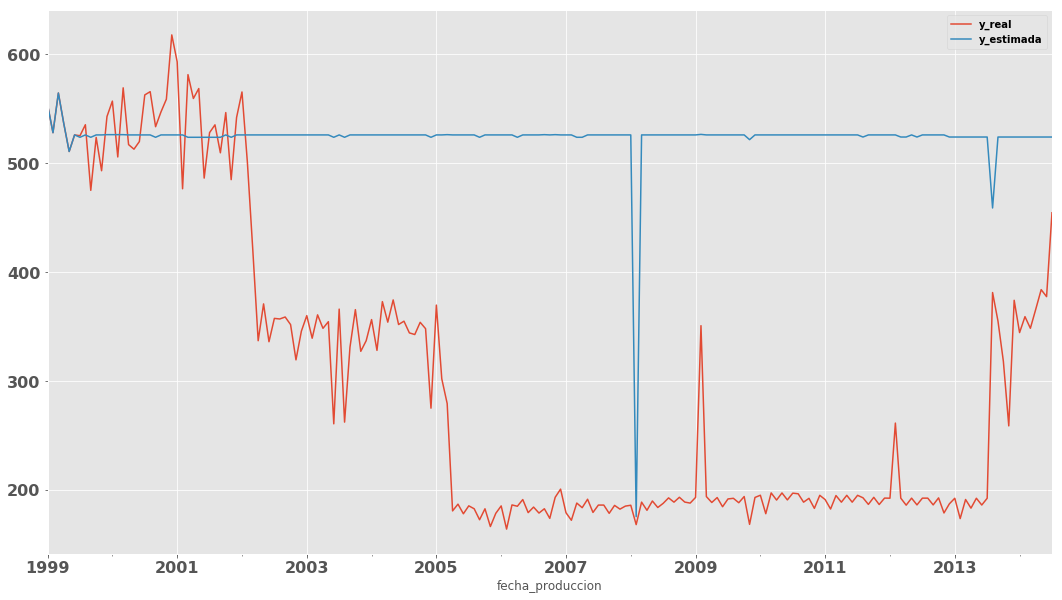

In [110]:
c.groupby('fecha_produccion')[['y_real','y_estimada']].median().plot(figsize=(18,10))

In [394]:
num_cols2=['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1','latitud']

In [395]:
df_pred[num_cols2].head(10)

,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,diff_t_6_t_5,diff_t_5_t_4,diff_t_4_t_3,diff_t_3_t_2,diff_t_2_t_1,diff_t_6_t_1,diff_t_5_t_1,diff_t_4_t_1,diff_t_3_t_1,aceleracion_de_produccion _t3t2_t2t1,aceleracion_de_produccion _t4t3_t2t1,latitud
0,637.03,653.38,628.78,652.170000,639.070000,614.430000,625.230000,-16.35,24.60,-23.390000,13.100000,24.640000,22.600000,38.950000,14.350000,37.740000,-11.540000,-48.030000,17.999684
1,653.38,628.78,652.17,639.070000,614.430000,625.230000,598.600000,24.60,-23.39,13.100000,24.640000,-10.800000,28.150000,3.550000,26.940000,13.840000,35.440000,23.900000,17.999684
2,628.78,652.17,639.07,614.430000,625.230000,598.600000,660.990000,-23.39,13.10,24.640000,-10.800000,26.630000,30.180000,53.570000,40.470000,15.830000,-37.430000,-1.990000,17.999684
3,652.17,639.07,614.43,625.230000,598.600000,660.990000,928.310000,13.10,24.64,-10.800000,26.630000,-62.390000,-8.820000,-21.920000,-46.560000,-35.760000,89.020000,51.590000,17.999684
4,639.07,614.43,625.23,598.600000,660.990000,928.310000,723.320000,24.64,-10.80,26.630000,-62.390000,-267.320000,-289.240000,-313.880000,-303.080000,-329.710000,204.930000,293.950000,17.999684
5,723.32,756.34,704.58,761.240000,715.450000,728.340000,701.470000,-33.02,51.76,-56.660000,45.790000,-12.890000,-5.020000,28.000000,-23.760000,32.900000,58.680000,-43.770000,17.999684
6,756.34,704.58,761.24,715.450000,728.340000,701.470000,658.471796,51.76,-56.66,45.790000,-12.890000,26.870000,54.870000,3.110000,59.770000,13.980000,-39.760000,18.920000,17.999684
7,704.58,761.24,715.45,728.340000,701.470000,658.471796,571.230490,-56.66,45.79,-12.890000,26.870000,42.998204,46.108204,102.768204,56.978204,69.868204,-16.128204,-55.888204,17.999684
8,761.24,715.45,728.34,701.470000,658.471796,571.230490,631.608239,45.79,-12.89,26.870000,42.998204,87.241306,190.009510,144.219510,157.109510,130.239510,-44.243102,-60.371306,17.999684
9,715.45,728.34,701.47,658.471796,571.230490,631.608239,590.743829,-12.89,26.87,42.998204,87.241306,-60.377749,83.841761,96.731761,69.861761,26.863557,147.619055,103.375953,17.999684


In [396]:
df_prueba[num_cols2].head(10)

,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,diff_t_6_t_5,diff_t_5_t_4,diff_t_4_t_3,diff_t_3_t_2,diff_t_2_t_1,diff_t_6_t_1,diff_t_5_t_1,diff_t_4_t_1,diff_t_3_t_1,aceleracion_de_produccion _t3t2_t2t1,aceleracion_de_produccion _t4t3_t2t1,latitud
0,128.44,114.34,130.68,125.76,130.43,122.07,230.21,14.10,-16.34,4.92,-4.67,8.36,6.37,-7.73,8.61,3.69,-13.03,-3.44,18.004202
1,114.34,130.68,125.76,130.43,122.07,230.21,245.40,-16.34,4.92,-4.67,8.36,-108.14,-115.87,-99.53,-104.45,-99.78,116.50,103.47,18.004202
2,130.68,125.76,130.43,122.07,230.21,245.40,239.44,4.92,-4.67,8.36,-108.14,-15.19,-114.72,-119.64,-114.97,-123.33,-92.95,23.55,18.004202
3,125.76,130.43,122.07,230.21,245.40,239.44,264.40,-4.67,8.36,-108.14,-15.19,5.96,-113.68,-109.01,-117.37,-9.23,-21.15,-114.10,18.004202
4,130.43,122.07,230.21,245.40,239.44,264.40,277.82,8.36,-108.14,-15.19,5.96,-24.96,-133.97,-142.33,-34.19,-19.00,30.92,9.77,18.004202
5,122.07,230.21,245.40,239.44,264.40,277.82,181.89,-108.14,-15.19,5.96,-24.96,-13.42,-155.75,-47.61,-32.42,-38.38,-11.54,19.38,18.004202
6,230.21,245.40,239.44,264.40,277.82,181.89,186.94,-15.19,5.96,-24.96,-13.42,95.93,48.32,63.51,57.55,82.51,-109.35,-120.89,18.004202
7,245.40,239.44,264.40,277.82,181.89,186.94,176.09,5.96,-24.96,-13.42,95.93,-5.05,58.46,52.50,77.46,90.88,100.98,-8.37,18.004202
8,239.44,264.40,277.82,181.89,186.94,176.09,190.26,-24.96,-13.42,95.93,-5.05,10.85,63.35,88.31,101.73,5.80,-15.90,85.08,18.004202
9,264.40,277.82,181.89,186.94,176.09,190.26,178.86,-13.42,95.93,-5.05,10.85,-14.17,74.14,87.56,-8.37,-3.32,25.02,9.12,18.004202


In [365]:
df_prueba = df_train[df_train.Pozo == 'MOLOACAN-132'].reset_index(drop=True)
df_prueba.tail()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster
119,MOLOACAN-132,2014-03-01,198.60,186.81,199.86,193.41,199.86,83.79,470.00,570.68,...,0,1,1,0,1,0,0,0,0,0
120,MOLOACAN-132,2014-04-01,186.81,199.86,193.41,199.86,83.79,470.00,570.68,546.27,...,0,1,1,0,0,0,0,1,0,3
121,MOLOACAN-132,2014-05-01,199.86,193.41,199.86,83.79,470.00,570.68,546.27,584.45,...,0,1,1,0,0,0,0,1,0,3
122,MOLOACAN-132,2014-06-01,193.41,199.86,83.79,470.00,570.68,546.27,584.45,228.59,...,0,1,1,0,0,0,0,1,0,3
123,MOLOACAN-132,2014-07-01,199.86,83.79,470.00,570.68,546.27,584.45,228.59,194.98,...,0,1,1,0,0,0,0,1,0,3


In [366]:
xx_test=df_prueba.iloc[5:6][num_cols]
xx_test

,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,diff_t_6_t_5,diff_t_5_t_4,...,equipo_perforacion_PM-78,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
5,165.26,184.97,179.55,98.88,107.86,92.73,137.63,158.68,-19.71,5.42,...,0,0,1,1,0,1,0,0,0,0


In [367]:
val = gbm_pickle.predict(xx_test)
val

array([339.57411076])

In [368]:
xx_test.iloc[0,0] = 165.26
xx_test.iloc[0,1] = 184.97
xx_test.iloc[0,2] = 179.55
xx_test.iloc[0,3] = 98.88
xx_test.iloc[0,4] = 107.86
xx_test.iloc[0,5] = 92.73
xx_test.iloc[0,6] = val
gen_cols(xx_test)

,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,diff_t_6_t_5,diff_t_5_t_4,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,y_real
5,165.26,184.97,179.55,98.88,107.86,92.73,339.574111,158.68,-19.71,5.42,...,0,1,1,0,1,0,0,0,0,137.63


In [369]:
xx_test

,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,diff_t_6_t_5,diff_t_5_t_4,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,y_real
5,165.26,184.97,179.55,98.88,107.86,92.73,339.574111,158.68,-19.71,5.42,...,0,1,1,0,1,0,0,0,0,137.63


In [370]:
val = gbm_pickle.predict(xx_test)
val

array([340.29982583])

In [371]:
xx_test.iloc[0,0] = 184.97
xx_test.iloc[0,1] = 179.55
xx_test.iloc[0,2] = 98.88
xx_test.iloc[0,3] = 107.86
xx_test.iloc[0,4] = 92.73
xx_test.iloc[0,5] = 340.299
xx_test.iloc[0,6] = val
gen_cols(xx_test)

,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,diff_t_6_t_5,diff_t_5_t_4,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,y_real
5,184.97,179.55,98.88,107.86,92.73,340.299,340.299826,158.68,5.42,80.67,...,0,1,1,0,1,0,0,0,0,137.63


In [372]:
val = gbm_pickle.predict(xx_test)
val

array([494.37214799])

# Prueba con pozos de baja produccion

Cluster 0 o 4

In [488]:
df_train.cluster.unique()

array([0, 3, 1, 2, 4], dtype=int64)

In [430]:
df_train.cluster_3.unique()

array([0, 1], dtype=uint64)

In [495]:
# pozos en cluster0
df_cluster = df_train[df_train.cluster == 0].reset_index(drop = True)
# pozos vivos
#pozos_vivos_cluster = df_cluster.groupby('Pozo').fecha_produccion.count()[df_cluster.groupby('Pozo').fecha_produccion.count() > 110].index
df_vivos_cluster = df_cluster[df_cluster.Pozo.isin(df_cluster)]
df_vivos_cluster.head()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster


In [496]:
# pozos en cluster
df_cluster = df_train[df_train.cluster == 4].reset_index(drop = True)
# pozos vivos
pozos_vivos_cluster = df_cluster.groupby('Pozo').fecha_produccion.count()[df_cluster.groupby('Pozo').fecha_produccion.count() > 110].index
df_vivos_cluster = df_cluster[df_cluster.Pozo.isin(pozos_vivos_cluster)]

In [497]:
df_vivos_cluster.head()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster


In [481]:
df_vivos_cluster.Pozo.unique()

array([], dtype=object)

In [482]:
df_vivos_cluster.Pozo.unique()[:]

array([], dtype=object)

In [483]:
df_vivos_cluster.shape

(0, 72)

In [484]:
df = None
del df

In [485]:
df_forcast = df_vivos_cluster

In [477]:
pozos_vivos = df_vivos_cluster.Pozo.unique()[:]
lag = 7
columna_inicial = 2

df_pred = pd.DataFrame()
for i in range(pozos_vivos.shape[0]):
    #selecciona un pozo vivo de la lista de pozos vivos
    df_prueba = df_forcast[df_forcast.Pozo == pozos_vivos[i]].reset_index(drop=True)
    print(df_prueba.Pozo.unique())
    #print('--1--')
    #     df_prueba['y_real'] = df_prueba.Produccion_barriles_t
    #toma los primeros 6 meses
    
    df_simul = df_prueba.iloc[0:6]
#     print(df_simul)
    #print('--2--')
    
    #forecast
    n_pred = df_prueba.shape[0] - 6
    print(n_pred)
    print('--3--')
    
    df_simul, pred = forecast(df_simul, n_pred, num_cols)
    
    #print(df_simul,pred)
    #print(df_simul.iloc[-1:])
    
    #df_simul.tail(10)
    #print(pred)
    #print('--4--')
    
    #guarda la misma fecha
    df_simul['fecha_produccion'] = df_prueba['fecha_produccion']
    #print(df_simul.values,pred)
    #print('--5--')
    
    #guarda los resultados en un dataframe
    df_pred = pd.concat([df_pred, df_simul], ignore_index=True)
    #print(df_pred)
    #print('--6--')
    #print('-------'*10)

['MOLOACAN-186']
140
--3--


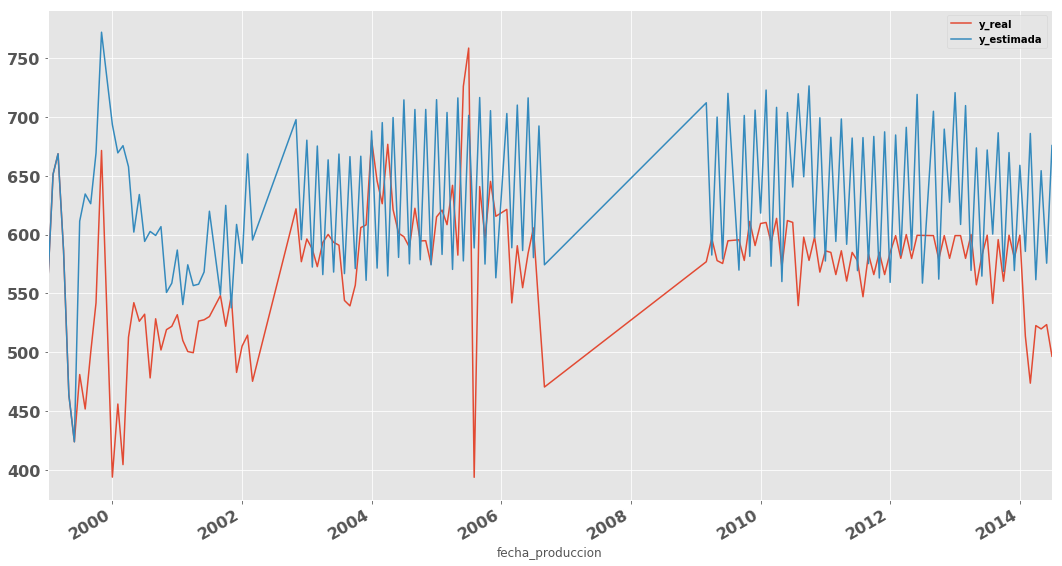

In [478]:
a = df_vivos[['Pozo','fecha_produccion','Produccion_barriles_t']]
a.columns = ['Pozo','fecha_produccion','y_real']
b = df_pred[['Pozo','fecha_produccion','Produccion_barriles_t']]
b.columns = ['Pozo','fecha_produccion','y_estimada']
c = a.merge(b,on=['Pozo','fecha_produccion'])
c.groupby('fecha_produccion')[['y_real','y_estimada']].median().plot(figsize=(18,10))